# Deformed Wing - Structural Modal Analysis

The following analysis shows the frequency of the structural modes for different wing tip deflections. The deformed shape has been obtained by various methods, each described in the corresponding subsection.

Version Control:
  * SHARPy version: v1.1.1-253-g98444c3-98444c3
  * Pazy wing model version: 5aba5afa2d395bf44b0df70ff520fce168864ca1
  * Test script version: `ngoiz/pazy-sharpy/03a_DeformedModal` 3ce2bf62abe89f938e4a7832010f57be13e0f60b (includes the appropriate version of SHARPy as a submodule)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import glob
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

# Deformed Mode Shapes from Aerodynamic Loading

Running an aeroelastic simulation with the wing set at 1, 5 and 7 degrees angle of attack, density=1.225 kg/m3, no gravity and varying the velocity between 1 and 60m/s. Note these are __not__ aeroelastic modes, just the modal frequencies of the deformed structure.

Each of the text files available `sharpy_alpha0100_skin1/mode_00.txt` shows the mode number (sorted in ascending frequency) and whether the case is with or without skin. The first column in the data is the wing tip vertical displacement in metres in an inertial frame aligned with the flow and the second the modal frequencies in rad/s.

In [2]:
results = []
for alpha in [1, 5, 7]:
    for skin in [True, False]:
        path = './sharpy_alpha{:04g}_skin{:g}/'.format(alpha * 100, skin)
        results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                       'alpha': alpha,
                       'skin': skin})

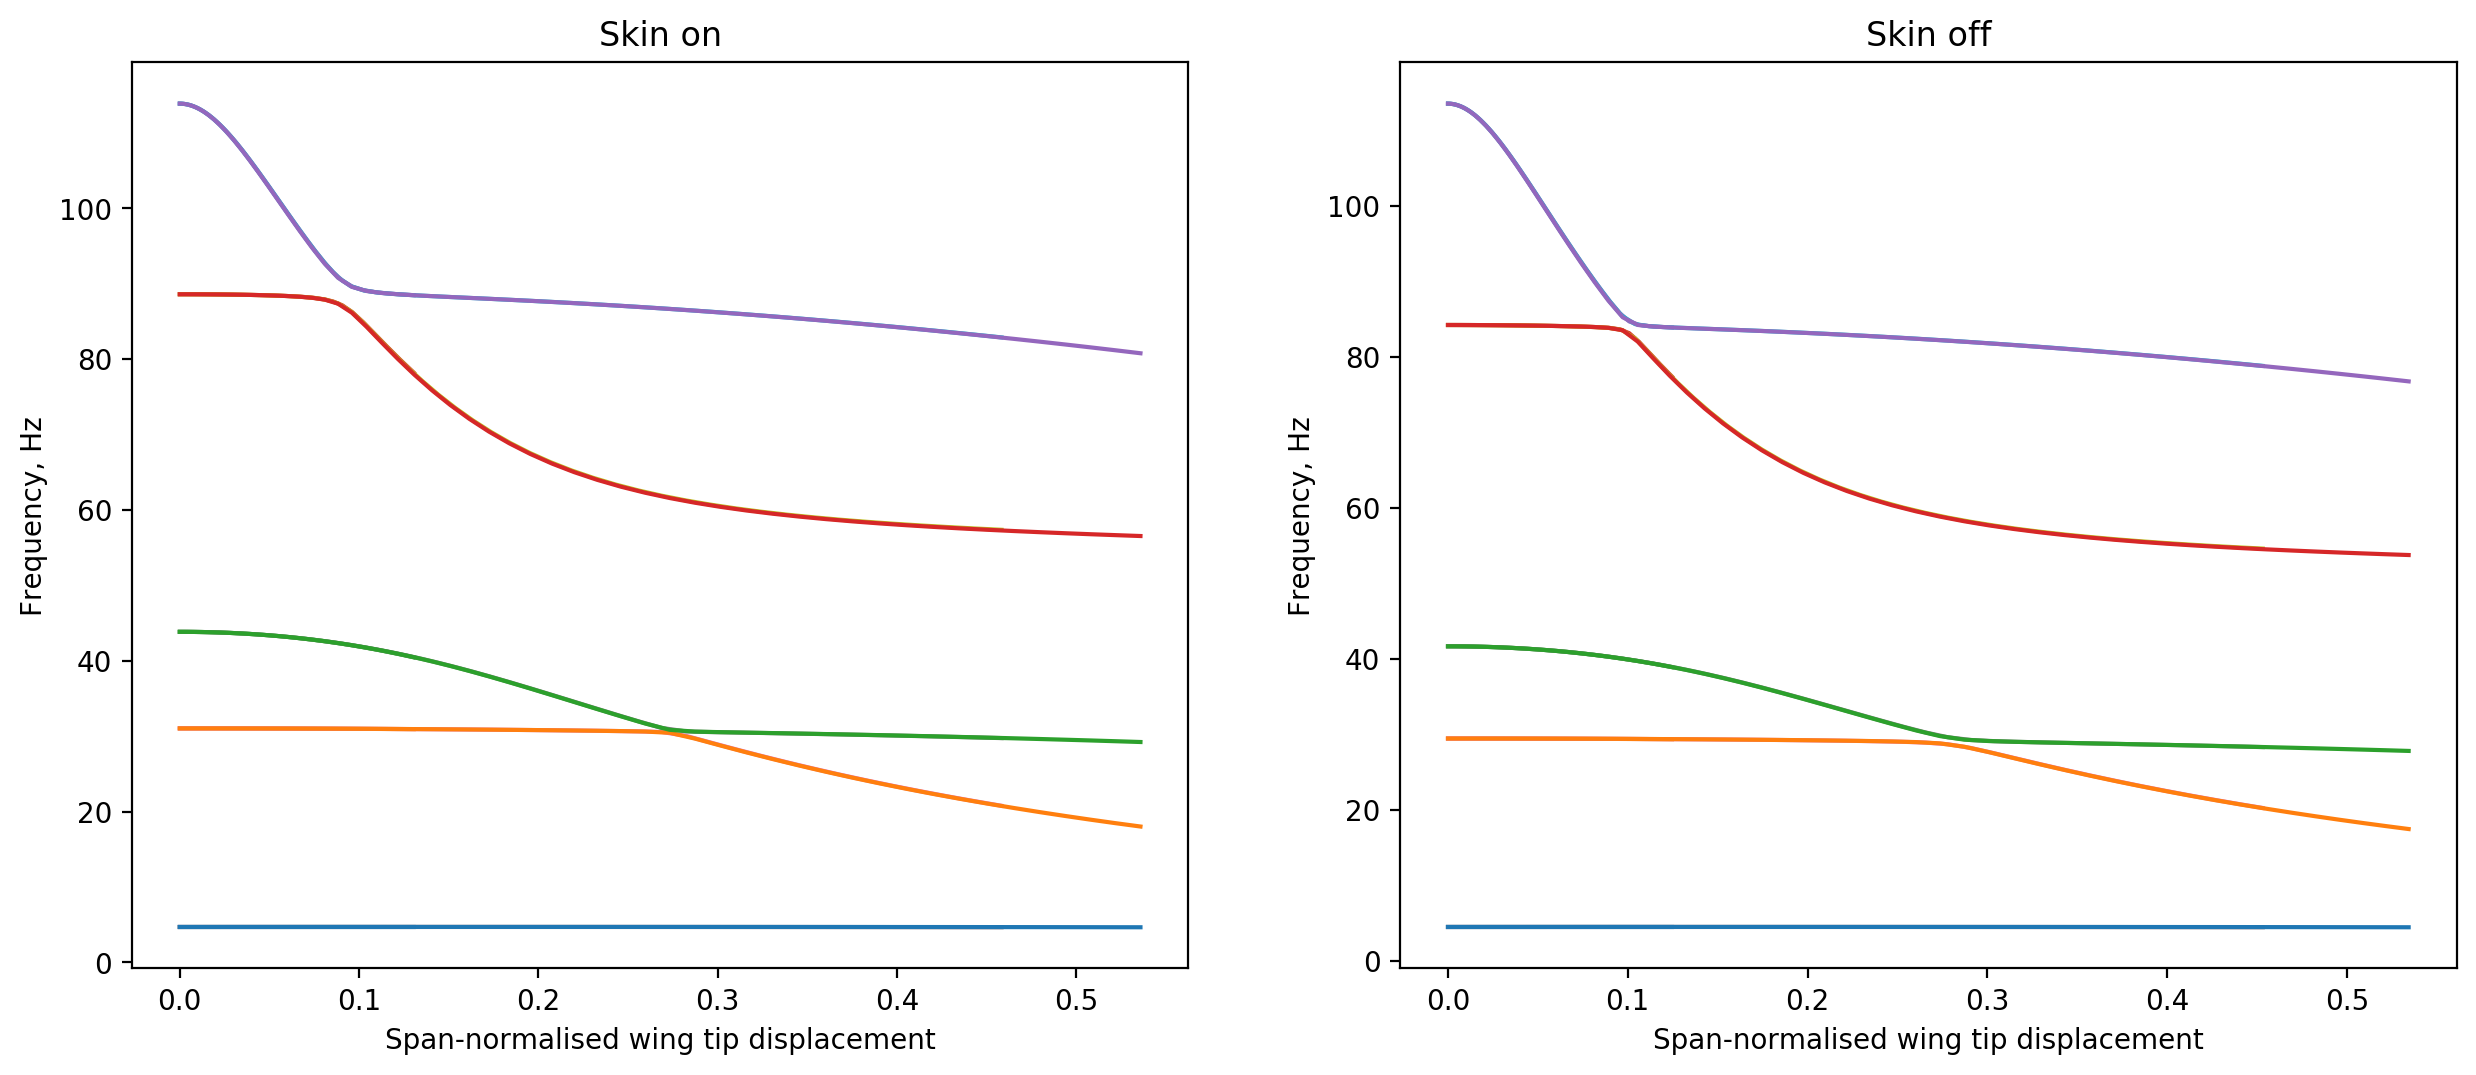

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

for case in results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot(case['data'][i_mode][:, 0] / 0.55, case['data'][i_mode][:, 1] / 2 / np.pi)
    
for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

# Deformed Mode Shapes from wing tip dead weight loading

These are the mode shapes obtained after loading the wing tip with a dead weight following the process in `./01_Bending/`. 

The results files `sharpy_bending_skin?` contain a file for each mode, ordered in ascending frequency. Each file has three columns: the first is the wing tip mass (kg), the second is the wing tip node vertical displacement and the final column is the mode frequency (rad/s).

In [4]:
bending_results = []
for skin in [True, False]:
    # SHARPy
    path = './sharpy_bending_skin{:g}/'.format(skin)
    bending_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                            'skin': skin,
                            'line_style': {'label': 'SHARPy', 'color': 'magenta', 'marker':'o', 'ms':2},
                           })
    
    # UM/NAST
    path = './UMNAST_bending_skin{:g}/'.format(skin)
    bending_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                            'skin': skin,
                            'line_style': {'label': 'UM/NAST', 'color': 'blue', 'marker':'o', 'ms':2},
                           })
    
    # NASTRAN
    if not skin:
        path = './UMNAST_parentFEM_bending_skin{:g}/'.format(skin)
        bending_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                                'skin': skin,
                                'line_style': {'label': 'NASTRAN', 'color': 'tab:orange', 'marker':'o', 'ms':2},
                               })

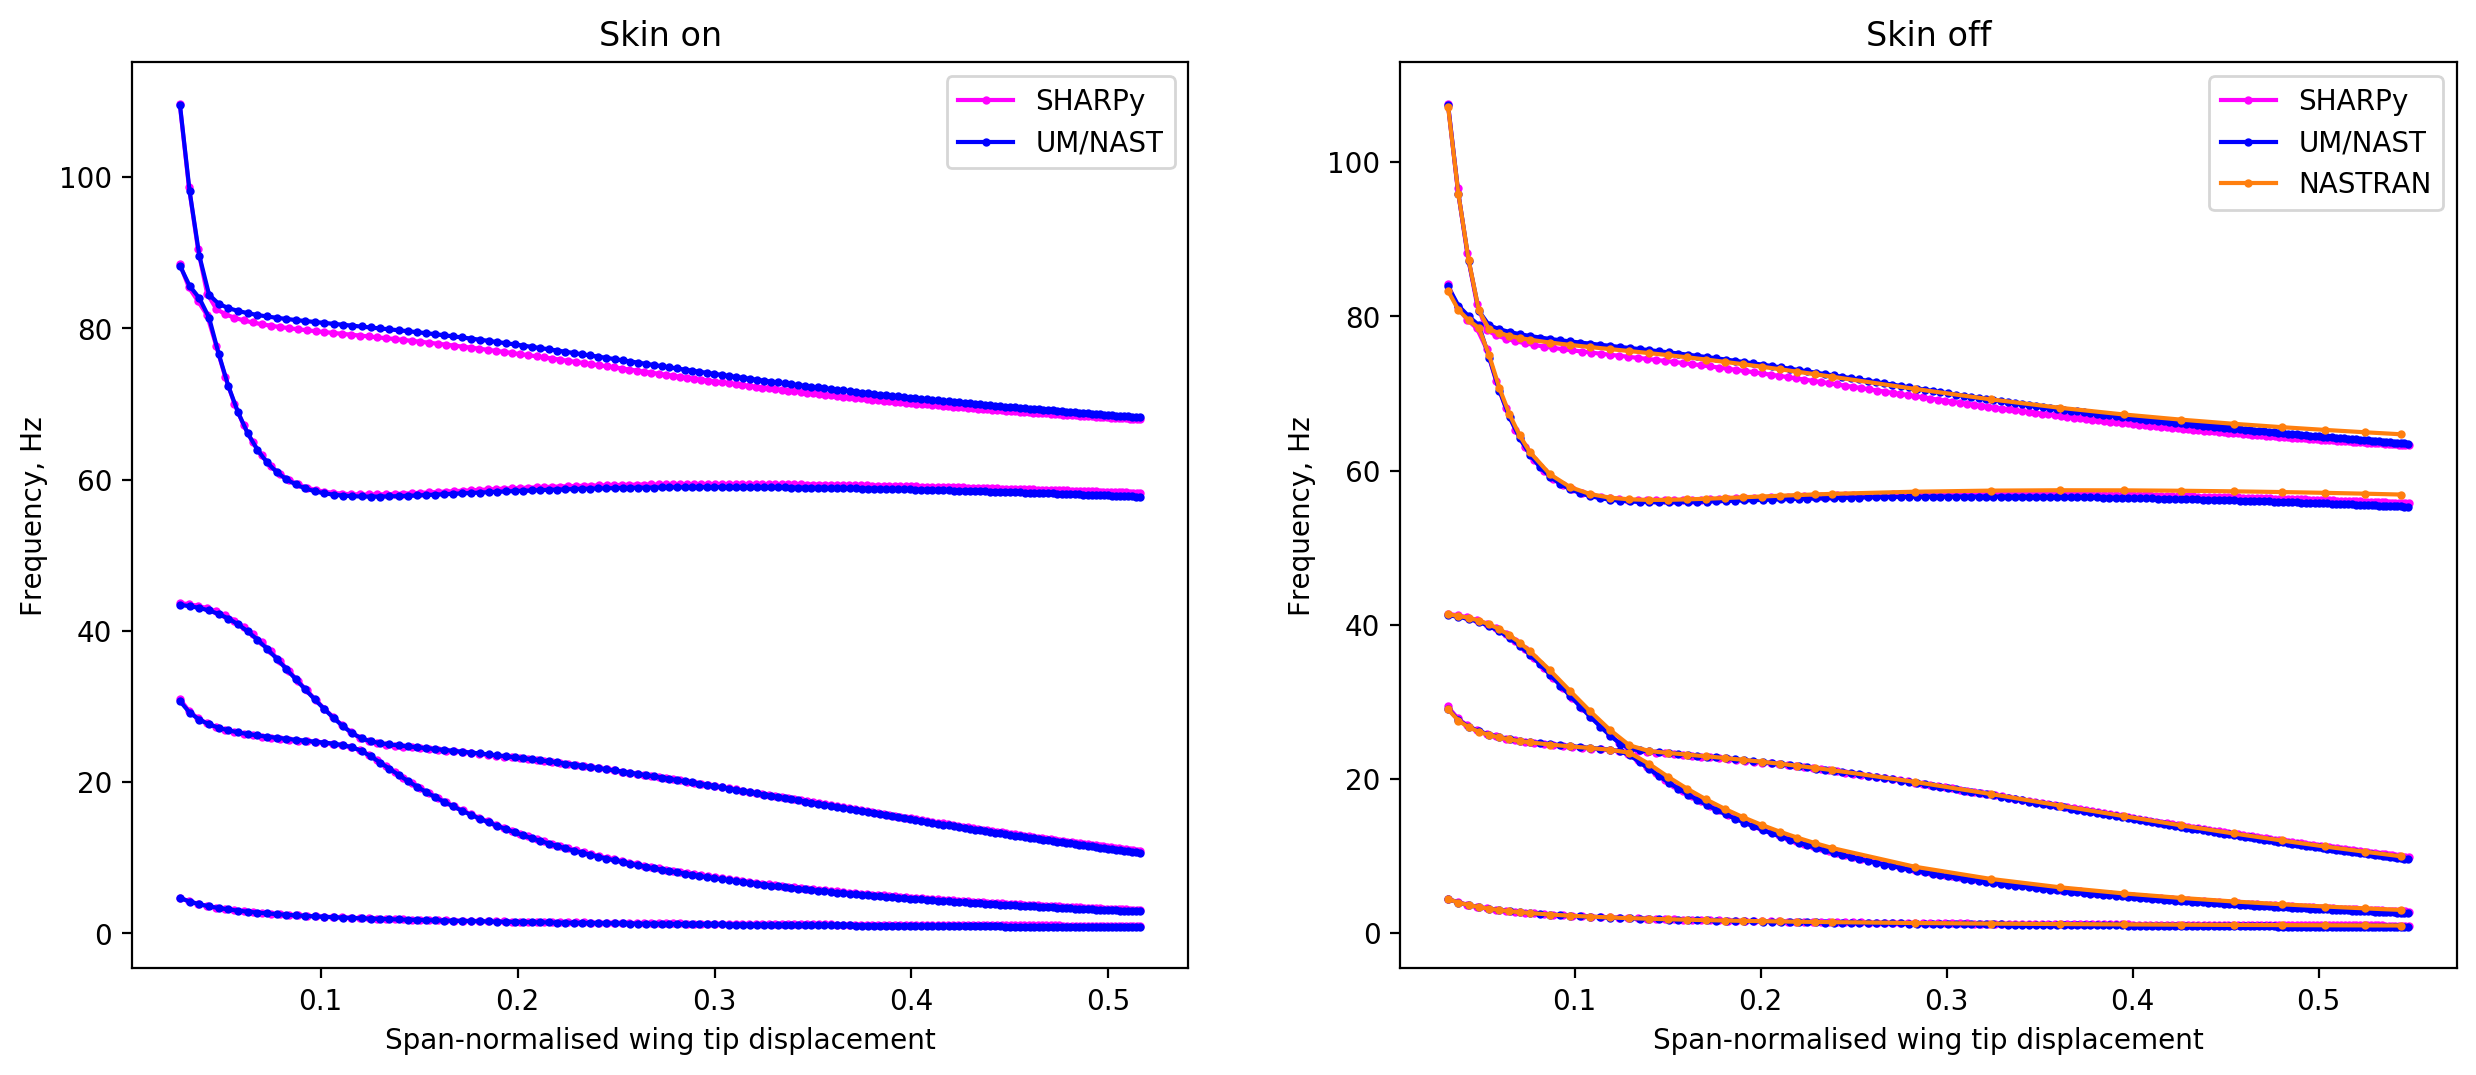

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]

for case in bending_results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot(np.abs(case['data'][i_mode][:, 1]) / 0.55, case['data'][i_mode][:, -1] / 2 / np.pi, **case['line_style'])
    
    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])
    
for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')

    
ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

# Tip follower force loading

The deformed shape is obtained by applying a follower force at the wing tip node, varying between 0N and 30N. This case is ran without any gravitational forces.

Results are contained in `sharpy_followerforce_skin?/`, where each of the files corresponds to a single mode (ordered by frequency) with three columns. The first is the follower force applied (N), the second is the wing tip node vertical displacement (m) and the third is the mode frequency (rad/s).

The SHARPy results are provided with the effect of the linearisation of the tip follower force applied and without, to assess the difference. The plots labelled `SHARPy w/ FF` include the effect. These are the ones in the `sharpy_followerforce_LAS_FF_skin?/` directory. An overview of this effect is provided in the [SHARPy documentation](https://ic-sharpy.readthedocs.io/en/develop/includes/linear/src/lingebm/FlexDynamic.html#sharpy.linear.src.lingebm.FlexDynamic.linearise_applied_forces).

In [6]:
ff_results = []
for skin in [True, False]:
    # SHARPy
    path = './sharpy_followerforce_skin{:g}/'.format(skin)
    ff_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                       'skin': skin,
                       'line_style': {'marker': 'o', 'label': 'SHARPy w/o FF', 'ms': 2, 'color': 'k'}})
    # Michigan
    path = './UMNAST_followerforce_skin{:g}/'.format(skin)
    ff_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                       'skin': skin,
                       'line_style': {'label': 'UM/NAST', 'color': 'b', 'ls':'--'}})
    
    if not skin:
        # Michigan FEM - NASTRAN
        path = './UMNAST_parentFEM_followerforce_skin{:g}/'.format(skin)
        ff_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(5)],
                           'skin': skin,
                           'line_style': {'label': 'NASTRAN', 'color': 'tab:orange', 'ls': '-.'}})
    path = './sharpy_followerforce_LAS_FF_skin{:g}/'.format(skin)
    n_modes = len(glob.glob(path + '/*'))
    ff_results.append({'data': [np.loadtxt(path + 'mode_{:02g}.txt'.format(i_mode)) for i_mode in range(n_modes)],
                   'skin': skin,
                   'line_style': {'marker': 'o', 'label': 'SHARPy w/FF', 'ms': 6, 'color': 'magenta',
                                  'mfc': 'none'}})
    

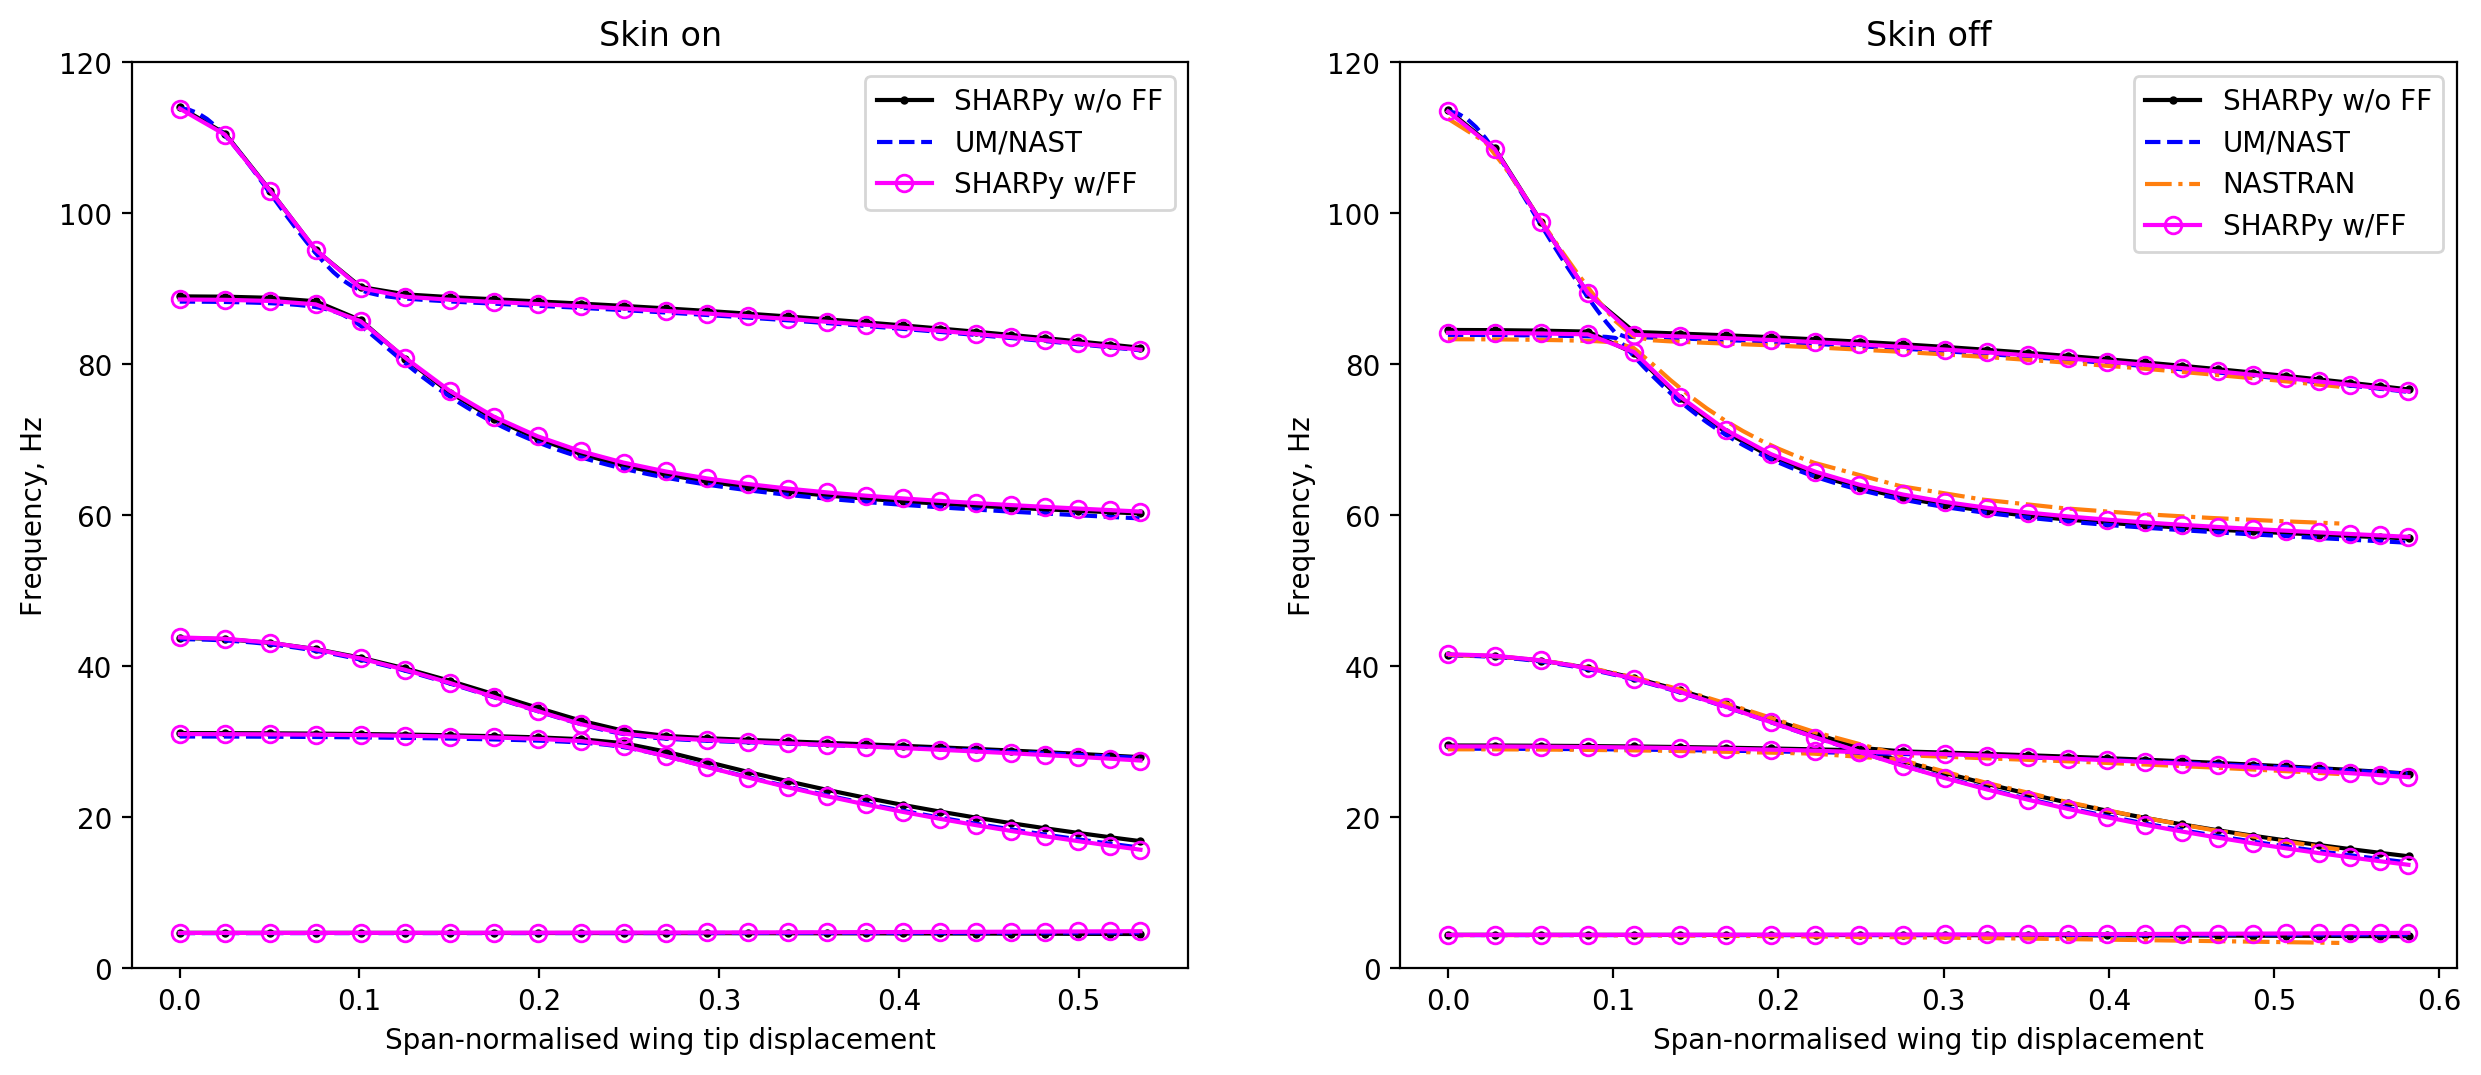

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]
for case in ff_results:
    for i_mode in range(len(case['data'])):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot((case['data'][i_mode][:, 1]) / 0.55, case['data'][i_mode][:, -1] / 2 / np.pi, **case['line_style'])

    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])

ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])

for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
    a.set_ylim(0, 120)
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

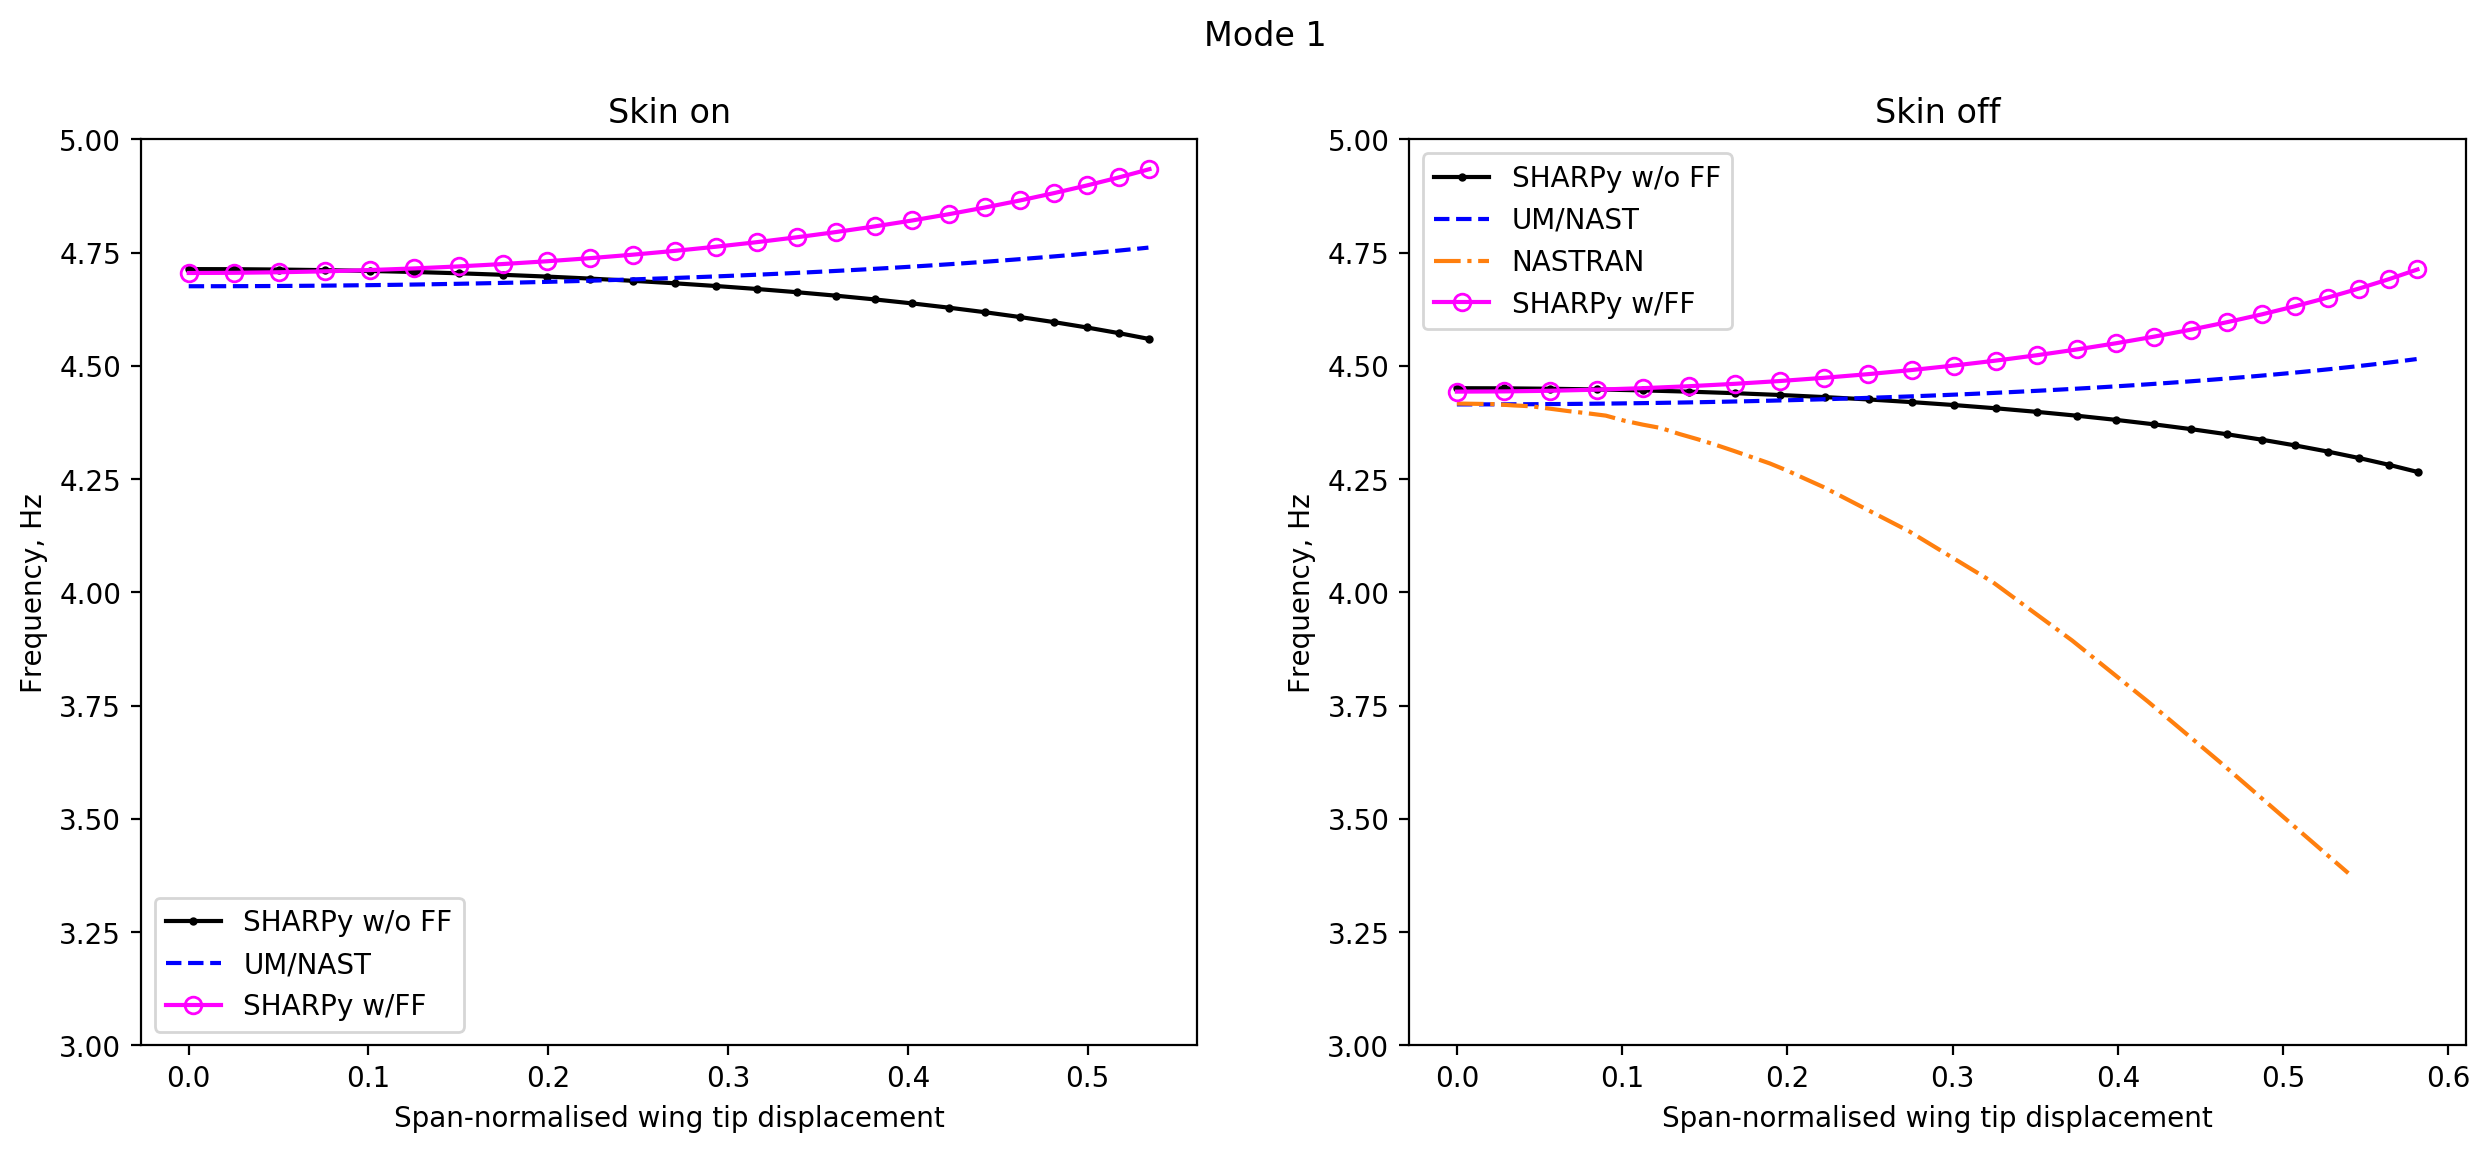

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]
for case in ff_results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot((case['data'][i_mode][:, 1]) / 0.55, case['data'][i_mode][:, -1] / 2 / np.pi, **case['line_style'])

    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])

ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])

for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
    a.set_ylim(3, 5)
plt.suptitle('Mode 1')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

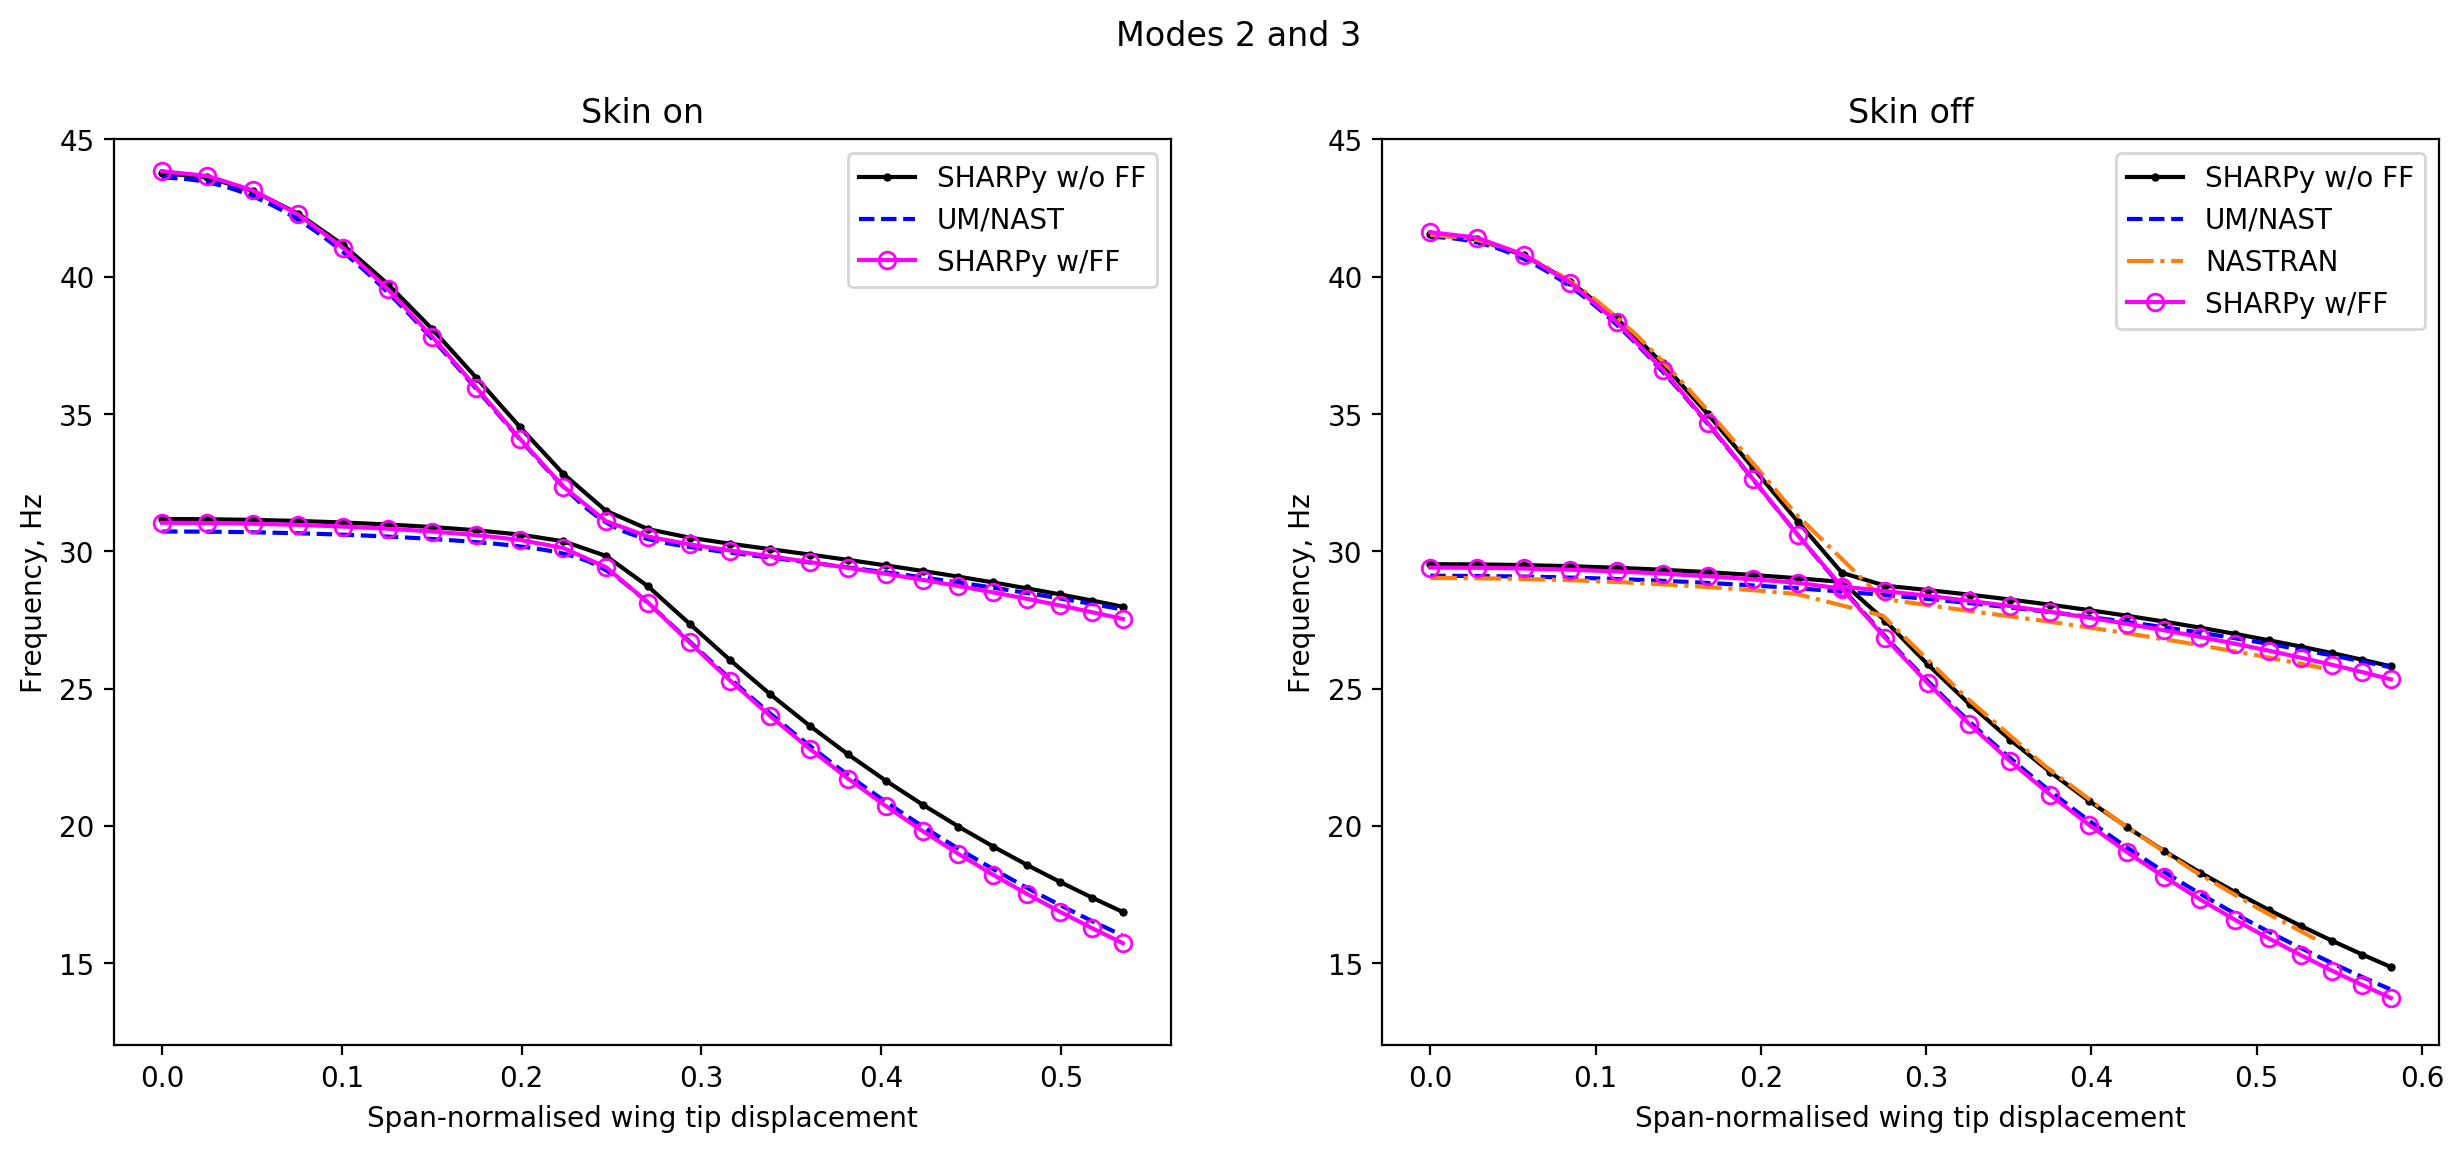

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]
for case in ff_results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot((case['data'][i_mode][:, 1]) / 0.55, case['data'][i_mode][:, -1] / 2 / np.pi, **case['line_style'])

    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])

ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])

for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
    a.set_ylim(12, 45)
plt.suptitle('Modes 2 and 3')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

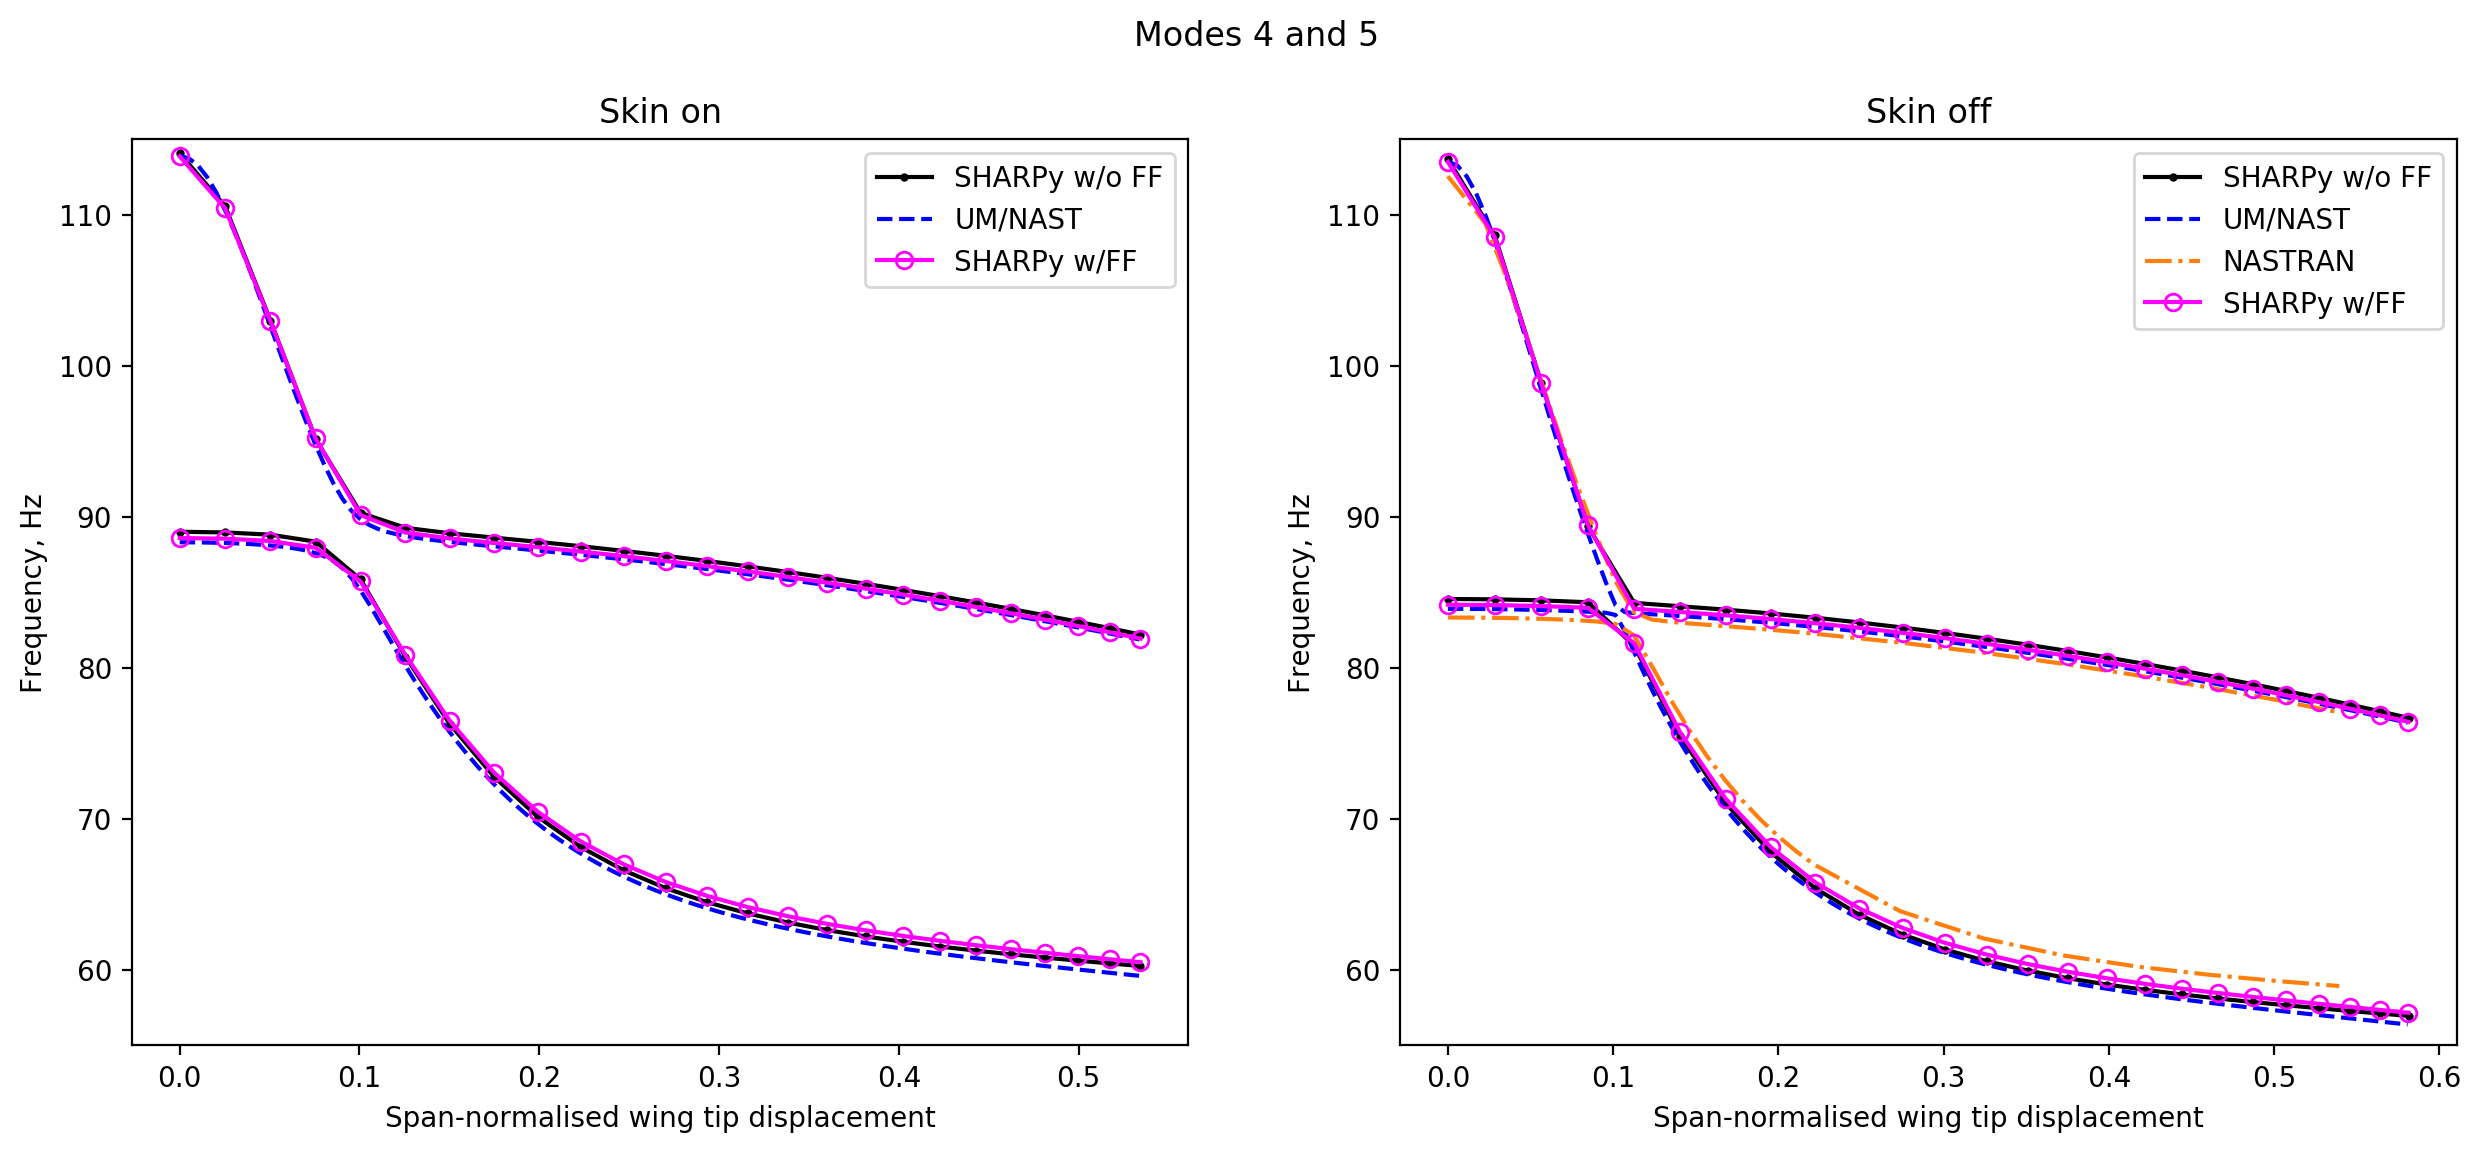

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]
for case in ff_results:
    for i_mode in range(5):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot((case['data'][i_mode][:, 1]) / 0.55, case['data'][i_mode][:, -1] / 2 / np.pi, **case['line_style'])

    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])

ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])

for a in ax:
    a.set_xlabel('Span-normalised wing tip displacement')
    a.set_ylabel('Frequency, Hz')
    a.set_ylim(55, 115)
plt.suptitle('Modes 4 and 5')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');

For verification purposes, we can also compare the wing-tip vertical displacement against the applied follower force. This is to ensure that discrepancies are due to inertial properties of the model rather than stiffness.

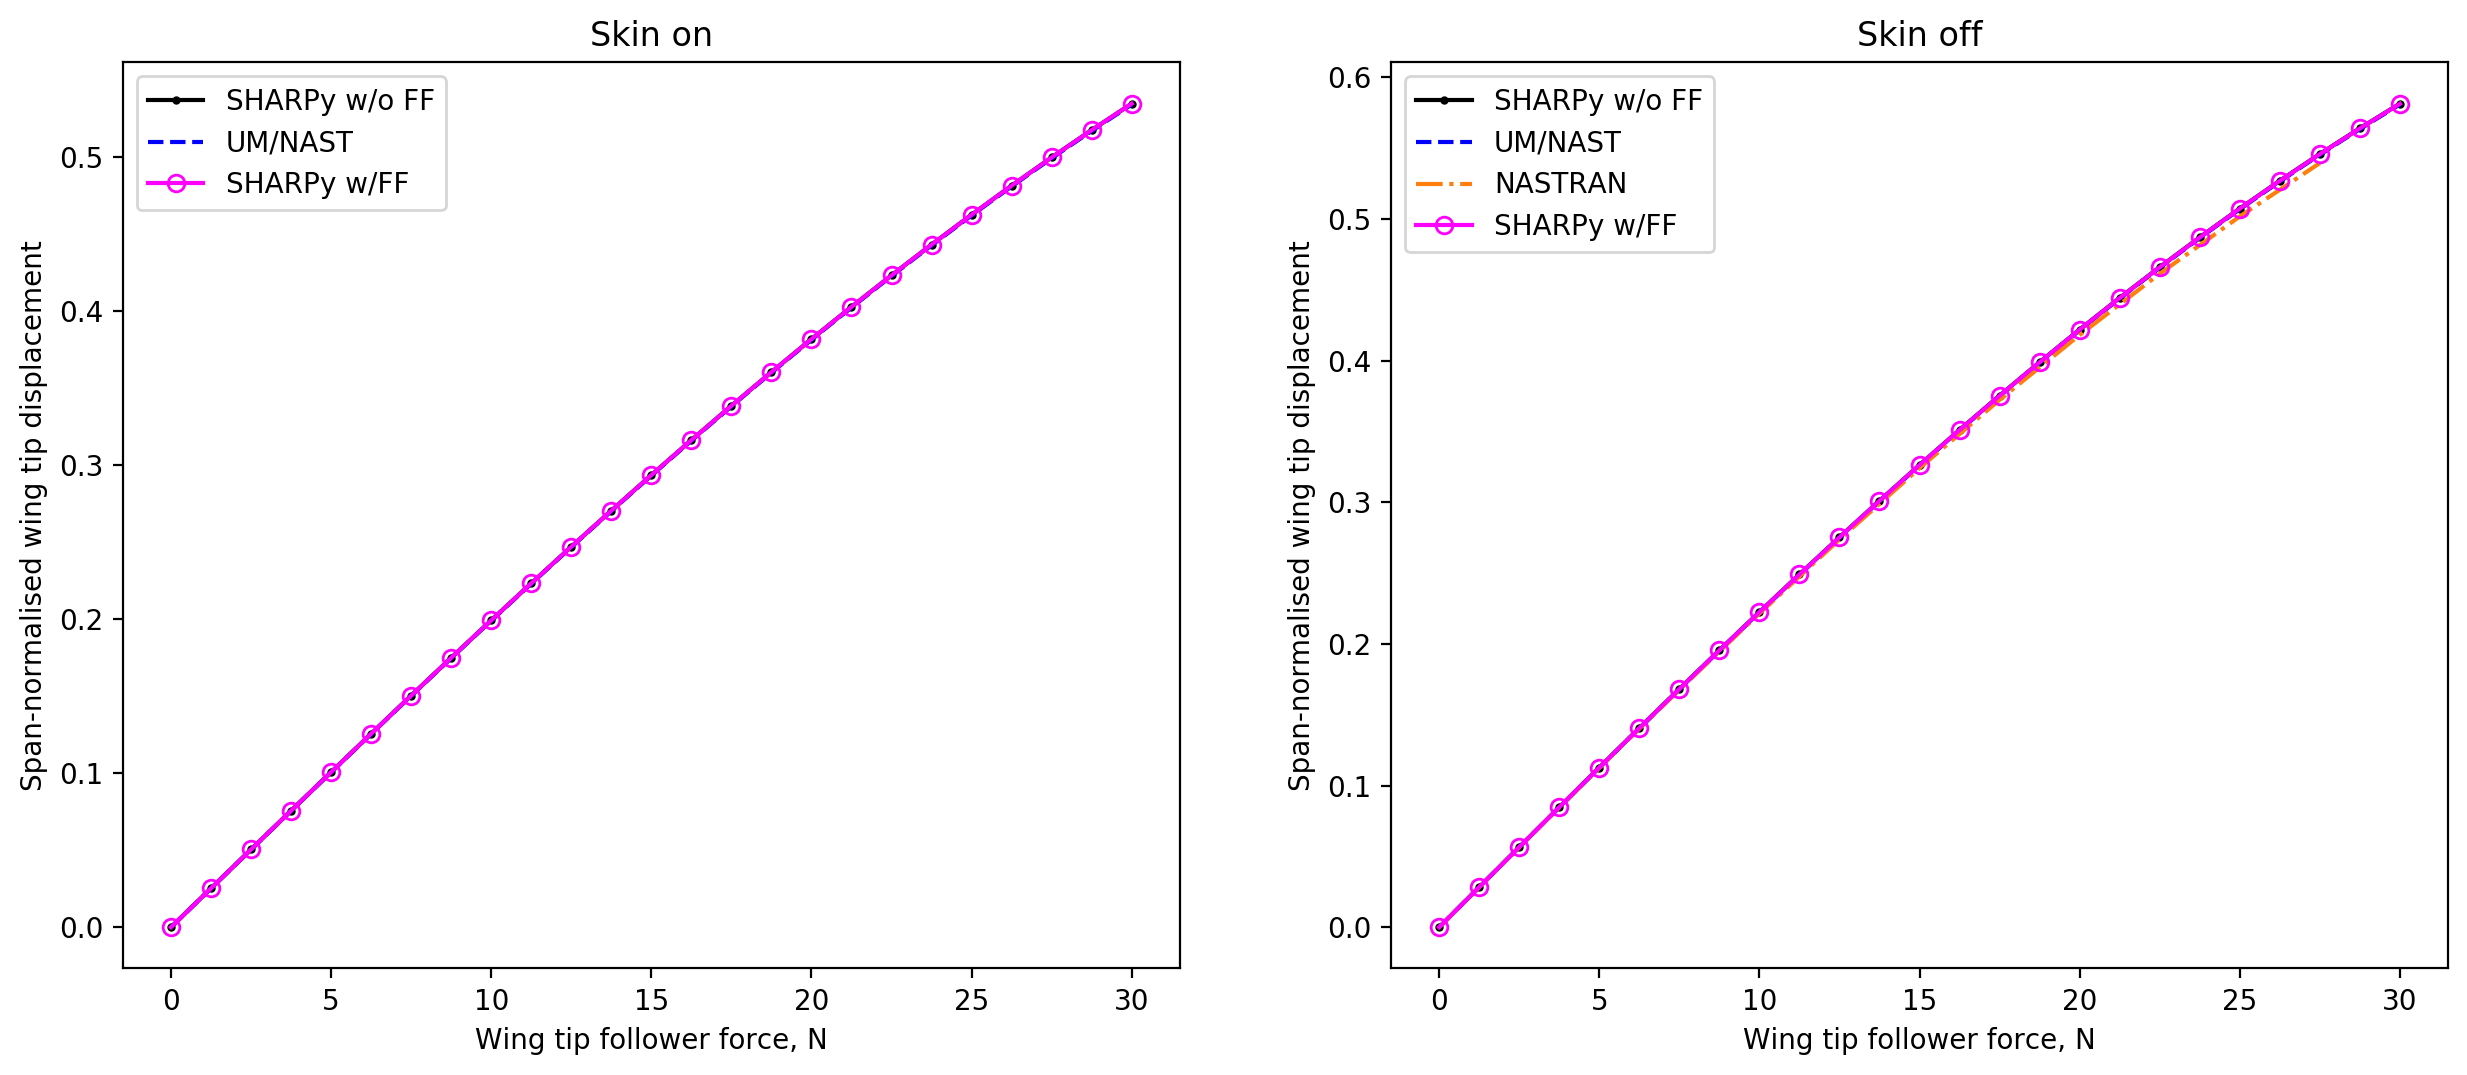

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
lines = [[], []]
labels = [[], []]
for case in ff_results:
    for i_mode in range(1):
        if case['skin']:
            a = ax[0]
        else:
            a = ax[1]
            
        a.plot(case['data'][i_mode][:, 0], case['data'][i_mode][:, 1] / 0.55, **case['line_style'])

    # legend
    if case['skin']:
        label_idx = 0
    else:
        label_idx = 1    
    lines[label_idx].append(mpl.lines.Line2D([0], [0], **case['line_style']))
    labels[label_idx].append(case['line_style']['label'])

ax[0].legend(lines[0], labels[0])
ax[1].legend(lines[1], labels[1])

for a in ax:
    a.set_ylabel('Span-normalised wing tip displacement')
    a.set_xlabel('Wing tip follower force, N')
ax[0].set_title('Skin on')
ax[1].set_title('Skin off');